# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [1]:
%%time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import helper

CPU times: user 744 ms, sys: 162 ms, total: 906 ms
Wall time: 1.88 s


The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). I've also split it into a training set and test set.

### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

There are plenty of transforms available, I'll cover more in a bit and you can read through the [documentation](http://pytorch.org/docs/master/torchvision/transforms.html). 

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Load images from the `Cat_Dog_data/train` folder, define a few transforms, then build the dataloader.

In [2]:
%%time
data_dir = 'Cat_Dog_data/train'

# DONE: compose transforms here
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

# DONE: create the ImageFolder
dataset = datasets.ImageFolder(data_dir, transform=transform)

# DONE: use the ImageFolder dataset to create the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

CPU times: user 128 ms, sys: 12.6 ms, total: 141 ms
Wall time: 241 ms


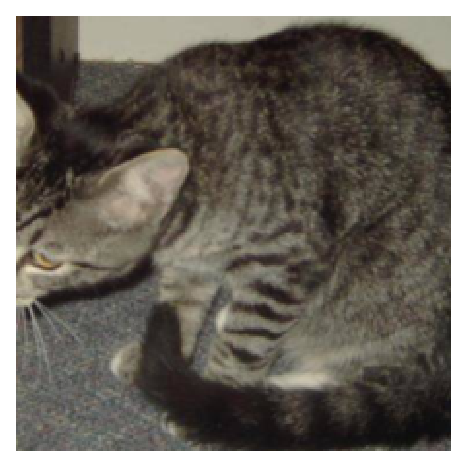

In [3]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

If you loaded the data correctly, you should see something like this (your image will be different):

<img src='assets/cat_cropped.png' width=244>

## Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.

>**Exercise:** Define transforms for training data and testing data below.

In [4]:
%%time
data_dir = 'Cat_Dog_data'
data_dir2 = 'Cat_Dog_data2'

# DONE: Define transforms for the training data and testing data
train_transforms = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                       ])    

test_transforms = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                      ])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir2 + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainsampler = torch.utils.data.sampler.SubsetRandomSampler(np.arange(64))

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=trainsampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

CPU times: user 16.7 ms, sys: 657 µs, total: 17.4 ms
Wall time: 32 ms


torch.Size([3, 224, 224])
<built-in method type of Tensor object at 0x7ff2b42a2750>
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
<built-in method type of Tensor object at 0x7ff2b42c4288>
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
<built-in method type of Tensor object at 0x7ff2b4258c18>
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
<built-in method type of Tensor object at 0x7ff2b4278480>
torch.Size([3, 224, 224])
CPU times: user 436 ms, sys: 31 ms, total: 467 ms
Wall time: 529 ms


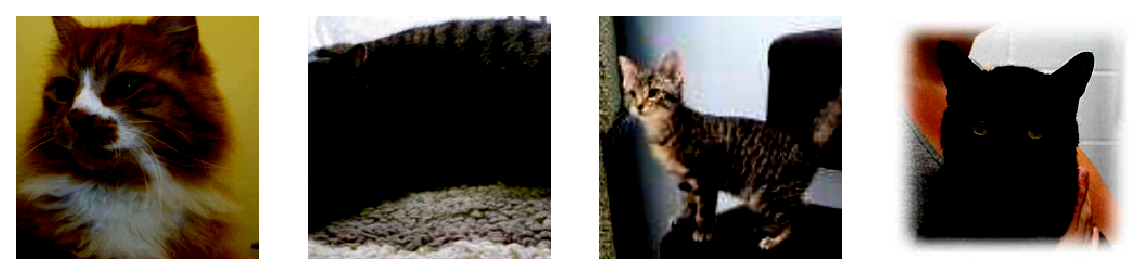

In [5]:
%%time
import numpy as np

# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    print(images[ii].shape)
    print(images[ii].type)
    ax = axes[ii]
    #disp_image = torch.cat((images[ii], images[ii], images[ii]))
    disp_image = images[ii]
    print(disp_image.shape)
    helper.imshow(disp_image, ax=ax, normalize=False)

CPU times: user 366 ms, sys: 23.9 ms, total: 390 ms
Wall time: 395 ms


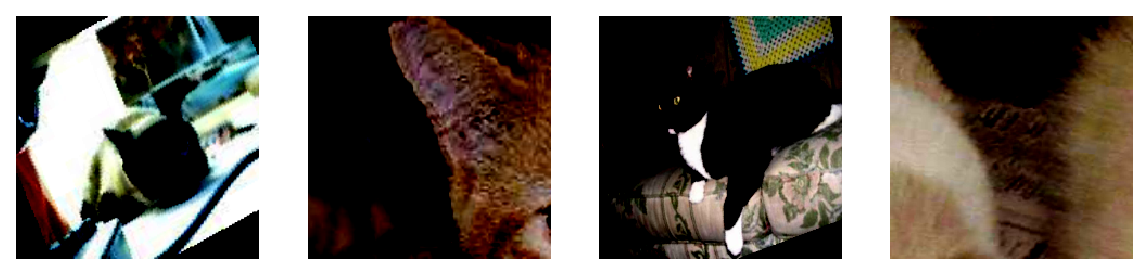

In [6]:
%%time
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    #disp_image = torch.cat((images[ii], images[ii], images[ii]))
    disp_image = images[ii]
    helper.imshow(disp_image, ax=ax, normalize=False)

Your transformed images should look something like this.

<center>Training examples:</center>
<img src='assets/train_examples.png' width=500px>

<center>Testing examples:</center>
<img src='assets/test_examples.png' width=500px>

At this point you should be able to load data for training and testing. Now, you should try building a network that can classify cats vs dogs. This is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. To be honest, you probably won't get it to work with a fully-connected network, no matter how deep. These images have three color channels and at a higher resolution (so far you've seen 28x28 images which are tiny).

In the next part, I'll show you how to use a pre-trained network to build a model that can actually solve this problem.

In [7]:
# Optional DONE: Attempt to build a network to classify cats vs dogs from this dataset

In [8]:
import random

manual_seed = 196
np.random.seed(manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [9]:
%%time
from torch import nn

# Define the network architecture here
n_input = 224*224*3
n_hidden = [64*64, 16*16, 4*4]
n_output = 2

model = nn.Sequential(
    nn.Linear(n_input, n_hidden[0]),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(n_hidden[0], n_hidden[1]),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(n_hidden[1], n_hidden[2]),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(n_hidden[2], n_output),
    nn.LogSoftmax(dim=1))

print(model)

Sequential(
  (0): Linear(in_features=150528, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5)
  (6): Linear(in_features=256, out_features=16, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5)
  (9): Linear(in_features=16, out_features=2, bias=True)
  (10): LogSoftmax()
)
CPU times: user 5.3 s, sys: 1.59 s, total: 6.89 s
Wall time: 7.6 s


In [10]:
%%time
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

CPU times: user 310 µs, sys: 0 ns, total: 310 µs
Wall time: 316 µs


In [11]:
%%time
import time
import datetime

# Train the network

epochs = 3
start_time = time.clock()
for e in range(epochs):
    running_loss = 0
    batch_counter = 0
    for images, labels in trainloader:
        #print(images.type)
        #print(images.shape)
        #print(labels.type)
        #print(labels.shape)
        print(labels)
        batch_counter += 1
        # Flatten images into 1D vector
        images = images.view(images.shape[0], -1)
        #print(images.shape)
        #print("--- %s seconds ---" % (time.time() - start_time))
        
        prefix = "(epoch {}/{} batch {}/{}) ".format(
            e + 1, epochs, batch_counter, len(trainloader))
        
        dtstr = datetime.datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")
        estr = "(elapsed {:.3f} sec) ".format(time.clock() - start_time)
        print(dtstr + estr + prefix + "Zeroing gradients...")
        optimizer.zero_grad()

        dtstr = datetime.datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")
        estr = "(elapsed {:.3f} sec) ".format(time.clock() - start_time)
        print(dtstr + estr + prefix + "Running forward pass...")
        output = model.forward(images)

        dtstr = datetime.datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")
        estr = "(elapsed {:.3f} sec) ".format(time.clock() - start_time)
        print(dtstr + estr + prefix + "Evaluating loss...")
        loss = criterion(output, labels)

        dtstr = datetime.datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")
        estr = "(elapsed {:.3f} sec) ".format(time.clock() - start_time)
        print(dtstr + estr + prefix + "Backpropagating...")
        loss.backward()

        dtstr = datetime.datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")
        estr = "(elapsed {:.3f} sec) ".format(time.clock() - start_time)
        print(dtstr + estr + prefix + "Stepping optimizer...")
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("(epoch {}/{}) Training loss is {:.4f}".format(
            e + 1, epochs, running_loss/len(trainloader)))
        
        # Run against validation data set
        test_losses = []
        test_accuracies = []

        with torch.no_grad():
            test_loss = 0
            n_test_images = 0
            n_correct_images = 0
            batch_counter = 0
            for test_images, test_labels in testloader:
                #print(test_images.type)
                #print(test_images.shape)
                #print(test_labels.type)
                #print(test_labels.shape)
                batch_counter += 1
                # Flatten images into 1D vector
                test_images = test_images.view(test_images.shape[0], -1)
        
                # Get the log probabilities from a forward pass
                log_ps = model.forward(test_images)
                # Update the test loss
                test_loss += criterion(log_ps, test_labels)
                # Get the class probabilities
                ps = torch.exp(log_ps)
                # Get the top result
                top_p, top_class = ps.topk(1, dim=1)
                # Evaluate the top result for each image
                equals = (top_class == test_labels.view(*top_class.shape))

                n_correct_images += torch.sum(equals)
                n_test_images += len(test_labels)

                accuracy = torch.mean(equals.type(torch.FloatTensor))
                print("    (batch {}/{}) accuracy = {:.3f}% ({}/{})".format(
                    batch_counter, len(testloader), accuracy.item()*100.0, torch.sum(equals), len(test_labels)))

            test_losses.append(test_loss/float(n_test_images))
            test_accuracies.append(100.0*n_correct_images.float()/float(n_test_images))
            elapsed = time.clock() - start_time

            dtstr = datetime.datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")
            estr = "(elapsed {:.3f} sec) ".format(time.clock() - start_time)
            print(dtstr + estr +
                "(epoch {}/{}) Total Validation Loss = {:.4f}, Validation Accuracy = {:.3f}% ({}/{})".format(
                e + 1, epochs, test_losses[-1], test_accuracies[-1], n_correct_images, n_test_images))

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1])
[2020-01-29 21:36:58] (elapsed 0.191 sec) (epoch 1/3 batch 1/2) Zeroing gradients...
[2020-01-29 21:36:58] (elapsed 0.191 sec) (epoch 1/3 batch 1/2) Running forward pass...
[2020-01-29 21:36:59] (elapsed 1.457 sec) (epoch 1/3 batch 1/2) Evaluating loss...
[2020-01-29 21:36:59] (elapsed 1.457 sec) (epoch 1/3 batch 1/2) Backpropagating...
[2020-01-29 21:39:09] (elapsed 12.946 sec) (epoch 1/3 batch 1/2) Stepping optimizer...
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1])
[2020-01-29 21:55:30] (elapsed 90.711 sec) (epoch 1/3 batch 2/2) Zeroing gradients...
[2020-01-29 21:57:13] (elapsed 95.163 sec) (epoch 1/3 batch 2/2) Running forward pass...
[2020-01-29 22:03:37] (elapsed 111.939 sec) (epoch 1/3 batch 2/2) Evaluating loss...
[2020-01

In [14]:
%%time

# Save the model                                                        
print(prefix + "Saving checkpoint...")

checkpoint = {
    'input_size': n_input,
    'output_size': n_output,
    'hidden_layers': n_hidden,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'e': e,
    'running_loss': running_loss}

#torch.save(checkpoint, 'checkpoint.pth')

(epoch 3/3 batch 2/2) Saving checkpoint...
CPU times: user 3.88 ms, sys: 408 µs, total: 4.29 ms
Wall time: 53.2 ms


In [15]:
# This relies on fc_model.py  
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model

In [16]:
# Load the checkpoint
# Doesn't seem to work because of absence of fc_model.py 
# and the fact that models produced by nn.Sequential() don't have a hidden_layers member
# Might could use:
import helper
import fc_model

#model = load_checkpoint('checkpoint.pth') <-- it was too big anyway for the notebook workspace

ValueError: shape mismatch: objects cannot be broadcast to a single shape

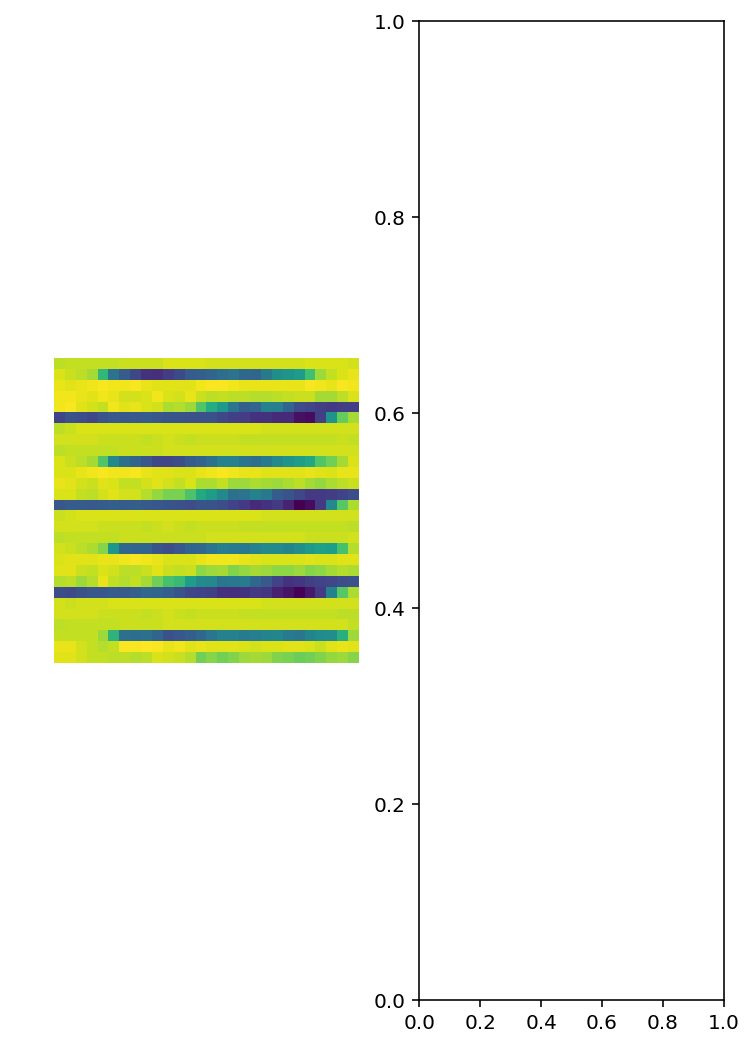

In [17]:
%%time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out the network!   

# Put the model into inference mode
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, n_input)

# Turn off gradients to speed up this part
with torch.no_grad():
    logprobs = model(img)
    
# Calculate the class probabilities (softmax) for img
ps = torch.exp(logprobs)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 224, 224), ps, version='Cat_Dog')

# Postscript

I probably spent too much time trying to get this to work. Running three epochs of two batches each ended up taking about 3.5 hours of wall time on the CPU, and because I couldn't figure out how to ensure that the two batchces included one batch of cats and one batch of dogs, it ended up training on only one and failing to be able to differentiate between them.

I also did not get the single-image display of results to work.

That said, it's time to move on...